# Python Import Organization Guide

Please import the libraries listed below.  
If any library is not installed on your local machine, run:

```bash
pip install -r requirements.txt


> **Note:** We use **PyTorch** as the main deep learning framework.  
> **PyTorch** provides support for:
> - Tensor computations  
> - GPU acceleration  
> - Automatic differentiation  
> - Building neural networks  
>
> **Torchvision** is used alongside PyTorch for computer vision tasks, including:
> - Pre-built datasets  
> - Pre-trained models  
> - Image transformations


In [1]:
# ----------------------------
# Standard Python Libraries
# ----------------------------
import os        # for file and directory operations
import json      # for reading/writing JSON files
import re        # for regular expressions
import glob      # for file pattern matching

# ----------------------------
# Third-Party Libraries
# ----------------------------
import torch
import torch.nn as nn                 # for building neural networks
import torchvision                    # for vision datasets and models
from torchvision.transforms import v2 # for image transformations
import numpy as np                     # numerical computations
import pandas as pd                    # data manipulation
import matplotlib.pyplot as plt        # plotting
from tqdm.notebook import tqdm         # progress bars
from sklearn.metrics import average_precision_score  # evaluation metric

# ----------------------------
# Self-Defined Modules
# ----------------------------
from CONFIG import *                   # configuration variables (DEVICE, paths, etc.)
from dataset import _Dataset           # custom dataset class
from util import *                     # custom utility functions (metrics, plotting)
from model import UNet, AttentionR2UNet, AttentionUNet, PretrainedAttentionR2UNet  # network architectures
from train import train_fn, CombinedLoss, Test, show_comparison  # training/testing functions

# ----------------------------
# Device setup
# ----------------------------
print("Device is:", DEVICE)


Device is: cuda


## Using GPU to Accelerate Computation

Deep learning training and inference can be significantly accelerated using a GPU.  
In PyTorch, you can detect whether a GPU is available and set the device accordingly.

```python
import torch

# Detect if GPU is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device in use:", DEVICE)


# Nature Dataset Setup and Exploration

We are using the **Nature dataset** for training a segmentation/classification model.  
The dataset contains images of butterflies and squirrels.

---

## 1. Unzip Dataset

If the dataset is compressed (e.g., `nature_dataset.zip`), unzip it using Python:

```python
import zipfile
import os

zip_path = "Nature.zip"
extract_path = "Nature"


## Data exploration


In [2]:
butterfly_count = 0
b_a_c = 0
squirrel_count = 0
s_a_c = 0

for content in os.listdir(TRAIN_DIR):
    if 'json' in content:
        if 'butterfly' in content:
            b_a_c +=1
        else:
            s_a_c +=1

    else:
        if 'butterfly' in content:
            butterfly_count += 1
        else: 
            squirrel_count +=1

print (f"Butterfly:{butterfly_count}, Mask:{b_a_c} Squirrel{squirrel_count}, Mask:{s_a_c}  ")
    

Butterfly:300, Mask:300 Squirrel300, Mask:300  


Found 600 image files
Found 200 image files
Butterfly height 205,width 246
Squirrel height 264,width 191
Average image height:187.8, Average image width:262.3


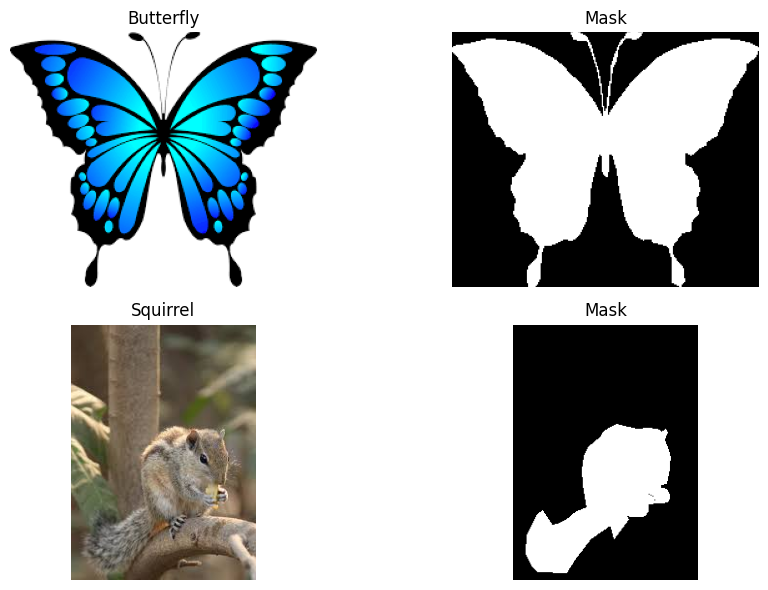

In [3]:
train_dataset = _Dataset(TRAIN_DIR,TRAIN_DIR)
test_dataset = _Dataset(TEST_DIR,TEST_DIR)

image, mask = train_dataset[0]   # assuming __getitem__ returns (img, mask)
s_i, s_m = train_dataset[300]

h0, w0 = image.shape[1], image.shape[2]
hm0, wm0 = mask.shape[0], mask.shape[1]

h1, w1 = s_i.shape[1], s_i.shape[2]
hm1, wm1 = s_m.shape[0], s_m.shape[1]
#tensor get height and width

print(f"Butterfly height {h0},width {w0}")
print(f"Squirrel height {h1},width {w1}")

heights = [img.shape[1] for img, _ in train_dataset]
widths = [img.shape[2] for img, _ in train_dataset]

avg_height = sum(heights)/len(heights)
avg_width = sum(widths)/len(widths)

print(f"Average image height:{avg_height:.1f}, Average image width:{avg_width:.1f}")

image1 , mask1 = to_numpy(image,mask)
s_i1,s_m1 = to_numpy(s_i,s_m)

# plot in 2x2 grid
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.title("Butterfly")
plt.imshow(image1)
plt.axis("off")

plt.subplot(2,2,2)
plt.title("Mask")
plt.imshow(mask1, cmap="gray")
plt.axis("off")

plt.subplot(2,2,3)
plt.title("Squirrel")
plt.imshow(s_i1)
plt.axis("off")

plt.subplot(2,2,4)
plt.title("Mask")
plt.imshow(s_m1, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


### Exploring the Dataset

- We have **300 images and 300 masks** for each of **butterfly** and **squirrel**.  
- Additionally, there are **100 images** in the dataset for both classes.  
- **Total:** 600 images and 200 masks.  

We also tried to **visualize the dataset**, and it looks quite accurate.  

- The **JSON annotations** were converted to masks using the `create_mask_from_json` function from our dataset module.  
- The results turned out to be **very accurate**.  

To determine a suitable crop size, we calculated the **average height and width** of the masks/images:  
- Found it to be around **200pixel ± some variation**, which can be used for cropping in preprocessing.


## Data Genearator + Augmentation 


#### Data Augmentation for Small Datasets

Sometimes, a **small dataset** requires additional data to improve model performance.  
- **PyTorch** provides various augmentation techniques that can be applied to images.  

> ⚠️ **Important:**  
> Read through the documentation carefully. Some augmentations might **accidentally corrupt the masks** if applied directly.  

- **Image augmentations** such as brightness, contrast, or saturation adjustments require **separate treatment** for masks.  
- **Geometric augmentations** (e.g., rotation, flipping, scaling) can be applied to both images and masks simultaneously using `v2.Compose`.


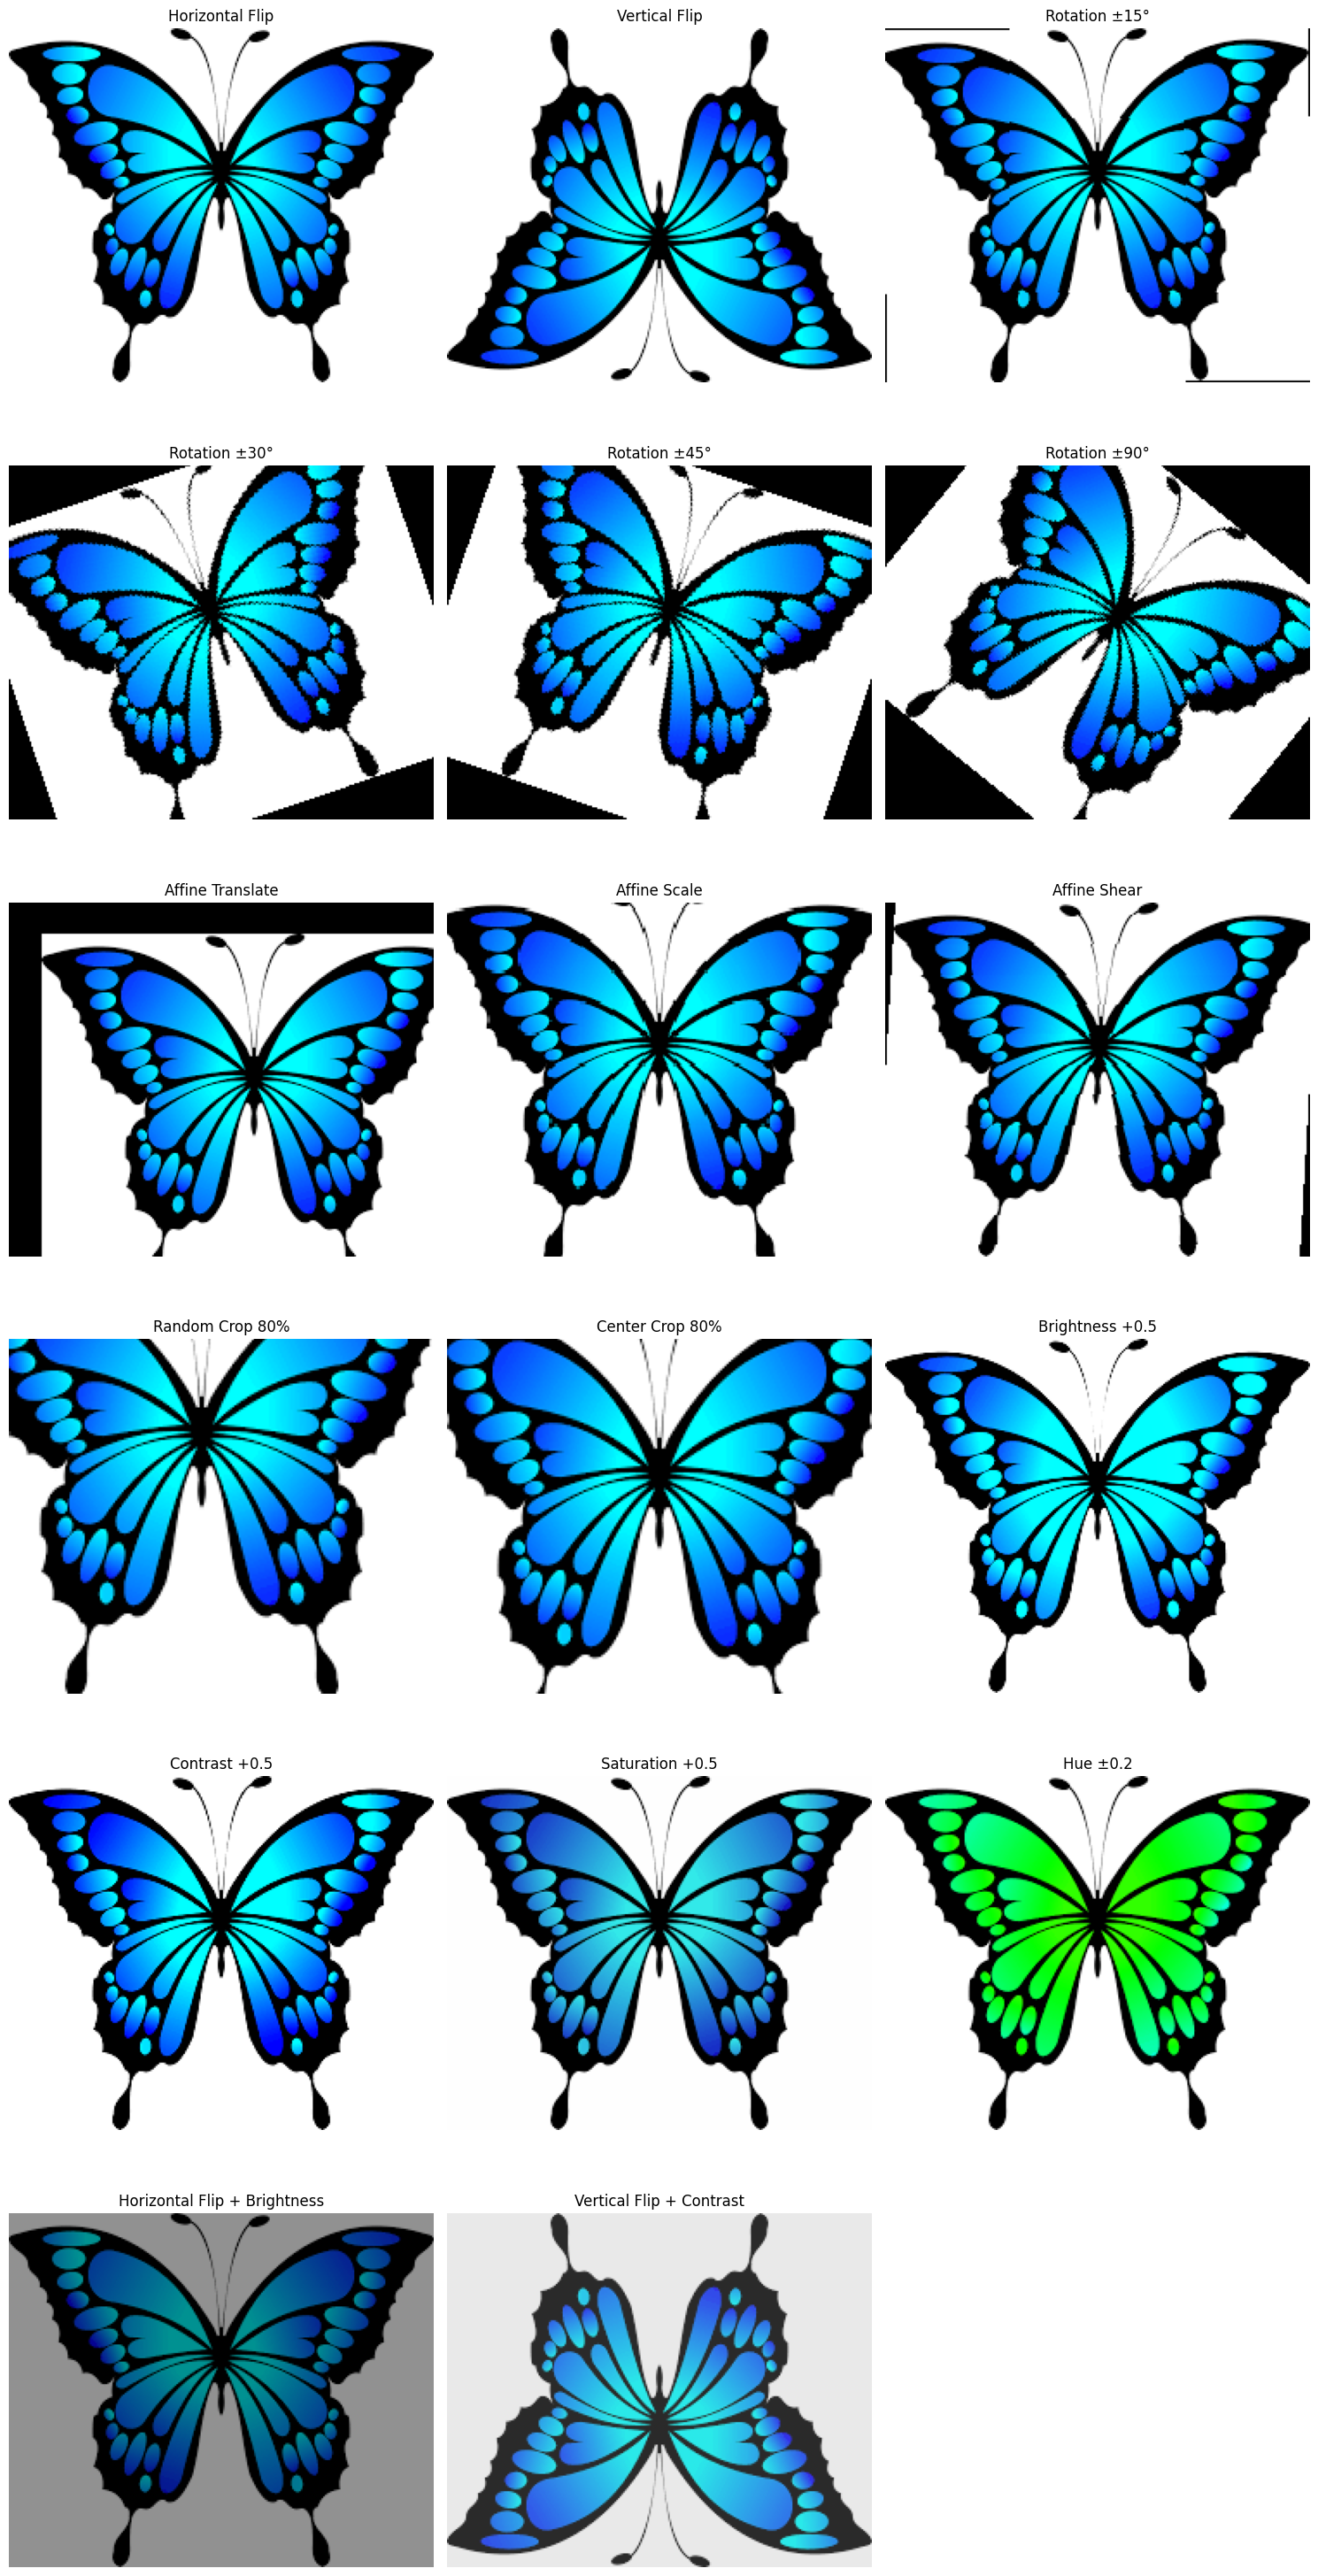

In [4]:
import math
# Pick one original image
image_tensor, _ = train_dataset[0]  # only image, mask ignored

# Same comprehensive augmentation dictionary
augmentations = {
    "Horizontal Flip": v2.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": v2.RandomVerticalFlip(p=1.0),
    "Rotation ±15°": v2.RandomRotation(degrees=15),
    "Rotation ±30°": v2.RandomRotation(degrees=30),
    "Rotation ±45°": v2.RandomRotation(degrees=45),
    "Rotation ±90°": v2.RandomRotation(degrees=90),
    "Affine Translate": v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    "Affine Scale": v2.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    "Affine Shear": v2.RandomAffine(degrees=0, shear=10),
    "Random Crop 80%": v2.RandomCrop(size=(int(image_tensor.shape[1]*0.8), int(image_tensor.shape[2]*0.8))),
    "Center Crop 80%": v2.CenterCrop(size=(int(image_tensor.shape[1]*0.8), int(image_tensor.shape[2]*0.8))),
    "Brightness +0.5": v2.ColorJitter(brightness=0.5),
    "Contrast +0.5": v2.ColorJitter(contrast=0.5),
    "Saturation +0.5": v2.ColorJitter(saturation=0.5),
    "Hue ±0.2": v2.ColorJitter(hue=0.2),
    "Horizontal Flip + Brightness": v2.Compose([v2.RandomHorizontalFlip(p=1.0), v2.ColorJitter(brightness=0.5)]),
    "Vertical Flip + Contrast": v2.Compose([v2.RandomVerticalFlip(p=1.0), v2.ColorJitter(contrast=0.5)]),
}

# Horizontal grid setup
cols = 3
num_augs = len(augmentations)
rows = math.ceil(num_augs / cols)

plt.figure(figsize=(cols * 5, rows * 5))

for i, (name, aug) in enumerate(augmentations.items()):
    transform = v2.Compose([aug, v2.ToDtype(torch.float32, scale=True)])
    aug_image = transform(image_tensor)
    image_np = aug_image.permute(1, 2, 0).numpy()
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(name, fontsize=12)

plt.tight_layout()
plt.show()

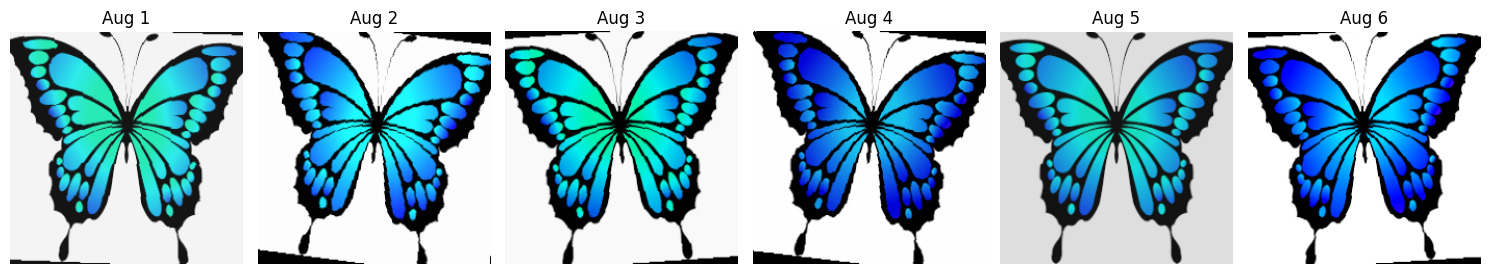

In [5]:

transform_aug = v2.Compose([
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomRotation(degrees=10), # small rotation
    v2.RandomResizedCrop(size=(224,224), scale=(0.9,1.0), ratio=(0.9,1.1)),  # minor crop+scale
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# Number of augmented versions to show
num_aug = 6

plt.figure(figsize=(15,3))

for i in range(num_aug):
    aug_image = transform_aug(image_tensor)  # apply augmentation
    
    # Convert tensor to numpy for visualization
    image_np = aug_image.permute(1,2,0).numpy()  # CHW -> HWC
    
    plt.subplot(1, num_aug, i+1)
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f"Aug {i+1}")

plt.tight_layout()
plt.show()


### Exploring Different Augmentation Methods

- Found that **crop size** actually affects performance significantly.  
- Using smaller crops might **reduce generalization**, especially with a small dataset.  
- However, smaller crops can help the model focus on **fine details**, such as the **tiny antennae of butterflies**.


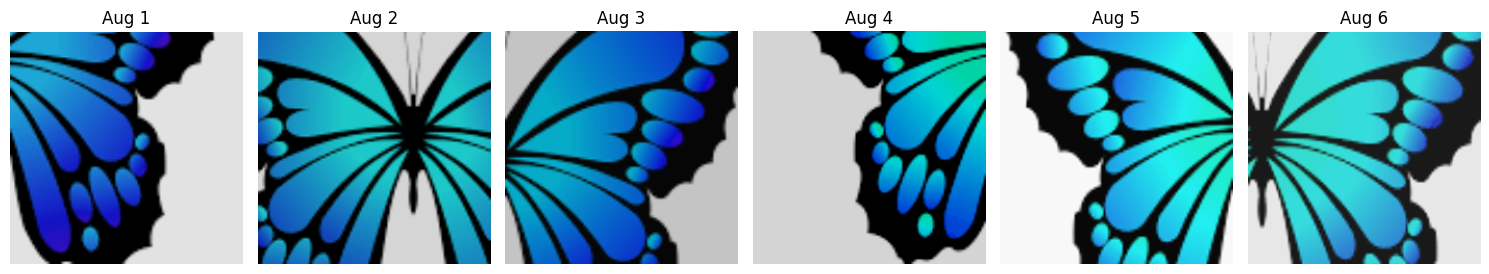

In [6]:
from util import Augmentation

crop_aug = Augmentation.MaskAwareRandomCrop(crop_size=(100,100), margin=10,default_return= "image")
del transform_aug.transforms[1]

plt.figure(figsize = (15,3))
for i in range(num_aug):
    img_cropped = crop_aug(image_tensor,_)  # apply augmentation
    
    # Convert tensor to numpy for visualization
    aug_image = transform_aug(img_cropped)
    image_np = aug_image.permute(1,2,0).numpy()  # CHW -> HWC
    
    plt.subplot(1, num_aug, i+1)
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f"Aug {i+1}")

plt.tight_layout()
plt.show()

### Random Augmentation to Increase Data Variety

Since the **antennae of butterflies are very thin**, we introduce **Mask-Aware Random Crop** to enlarge these tiny features so that the model can recognize them more effectively.  

We then **compare the augmented pipeline with the non-augmented pipeline** under the same hyperparameters to evaluate the effect of augmentation on performance.

---

#### Augmentation Pipeline Overview

1. **Augmentation Class in `util.py`**  
   - Handles potential **image-mask conflicts** for color transformations that could cause errors during testing.  
   - Ensures that **color augmentations** are applied only to images, not masks.

2. **Geometric Transformations (PyTorch v2)**  
   - Applied using `v2.Compose` and include:  
     - Random horizontal and vertical flips  
     - Random rotation  
     - Center crop and resize  

3. **Combined Pipeline**  
   - Masks are first processed using **Mask-Aware Random Crop**.  
   - Geometric transformations are applied **synchronously** to both image and mask.  
   - Images are then post-processed to tensors (`ToImage`, `ToDtype`) for model input.  

> **Note:** Although `torchvision.transforms` provides similar functionality, we use our **custom pipeline** to ensure compatibility with mask handling and avoid test errors.


### Mask-Aware Hard Attention Cropping

- The **crop size is set to 200**.  
- Before any other augmentation, we **keep the original image** but apply a **hard attention crop**:  
  - This crop is **mask-aware**.  
  - It **focuses on the region around the mask** while **avoiding cutting through the mask itself**.  
- The goal is to **enlarge the important features** (e.g., butterfly antennae) for better recognition without losing mask integrity.  
- This ensures that subsequent augmentations (geometric or photometric) are applied to **relevant regions**.


In [7]:

from util import Augmentation

normalize = v2.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
# ==========================================================
# 1) image-only photometric post transforms (applied after geometric ops)
# ==========================================================
img_post = v2.Compose([
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  # [0,1]
])

# ==========================================================
# 2) plain (resize only, no augmentation)
# ==========================================================
resize_transform = v2.Compose([
    v2.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])
train_dataset = _Dataset(TRAIN_DIR, TRAIN_DIR, transform=resize_transform)
test_dataset  = _Dataset(TEST_DIR,  TEST_DIR,  transform=resize_transform)

# ==========================================================
# 3) (resize, synchronized with masks)
# ==========================================================
transform_aug = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomVerticalFlip(p = 0.5),
    v2.CenterCrop(200),
    v2.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])
train_dataset_aug = _Dataset(TRAIN_DIR, TRAIN_DIR, transform=transform_aug)

# ==========================================================
# 4) mask-aware crop + synchronized geometric ops (correct for masks)
# ==========================================================
crop_aug = Augmentation.MaskAwareRandomCrop(crop_size=(200,200))  # crop before resize
sync_geom = Augmentation.SynchronizedGeometric(
    hflip_p=0.5,
    rotate_deg=10.0,
    resize_to=(IMAGE_HEIGHT, IMAGE_WIDTH),
    img_post=v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ])
)
combined_aug = Augmentation.CombinedAugmentation(
    crop_aug=crop_aug,
    transform_pair=sync_geom
)

train_dataset_cropaug = _Dataset(TRAIN_DIR, TRAIN_DIR, transform=combined_aug)

Found 600 image files
Found 200 image files
Found 600 image files
Found 600 image files


In [8]:
# check the dataset treatment tensor shape

print(f"plain img={tuple(train_dataset[0][0].shape)} mask={tuple(train_dataset[0][1].shape)} | aug img={tuple(train_dataset_aug[0][0].shape)} mask={tuple(train_dataset_aug[0][1].shape)} | cropaug img={tuple(train_dataset_cropaug[0][0].shape)} mask={tuple(train_dataset_cropaug[0][1].shape)}")
#debug use


plain img=(3, 512, 512) mask=(512, 512) | aug img=(3, 512, 512) mask=(512, 512) | cropaug img=(3, 512, 512) mask=(512, 512)


### Image and Mask Shapes Across Augmentation Pipelines

We observe the shapes of images and masks under different augmentation pipelines:

| Pipeline       | Image Shape     | Mask Shape    |
|----------------|----------------|---------------|
| Plain          | (3, 512, 512)  | (512, 512)    |
| Augmented      | (3, 512, 512)  | (512, 512)    |
| Crop + Augmented | (3, 512, 512) | (512, 512)    |

- **Observation:**  
  - The **image and mask shapes are consistent** across all pipelines.  
  - In some cases, we apply `unsqueeze` to the mask to **add a channel dimension** (`C = 1`) so that the mask becomes `(1, 512, 512)`.  
  - This ensures compatibility with **PyTorch models** expecting a channel dimension for masks.


### Differences Between PyTorch and NumPy Tensor Shapes

When working with images and masks, it is important to understand the **shape conventions** used by PyTorch and NumPy:

1. **PyTorch (Tensor)**  
   - Shape format: **(C, H, W)**  
     - `C` = number of channels (e.g., 3 for RGB)  
     - `H` = height  
     - `W` = width  
   - Example: `(3, 512, 512)` for an RGB image.  

2. **NumPy (Array/Image)**  
   - Shape format: **(H, W, C)**  
     - `H` = height  
     - `W` = width  
     - `C` = number of channels  
   - Example: `(512, 512, 3)` for an RGB image.  

> **Key Takeaways:**  
> - PyTorch expects **channels-first** `(C, H, W)` for most models.  
> - NumPy typically uses **channels-last** `(H, W, C)`.  
> - Always check the framework requirements before applying transformations or feeding into a model.  
> - Masks without channels can be `(H, W)` in both PyTorch and NumPy, but you may need to `unsqueeze` to add a channel: `(1, H, W)` for PyTorch.


In [9]:
# check the transformation from json
for i, (img, mask) in enumerate(train_dataset):
    max_val = mask.max()
    if max_val > 1.0 or max_val <= 0.0:
        print(f"[Warning] Sample {i} has max value {max_val}")

for i, (img, mask) in enumerate(test_dataset):
    max_val = mask.max()
    if max_val > 1.0 or max_val <= 0.0:
        print(f"[Warning] Test sample {i} has max value {max_val}")

This code **checks the masks** in the training and test datasets for any **invalid values** (outside the range (0, 1]) and prints a warning if found.


### Visualization of Result

Found 600 image files


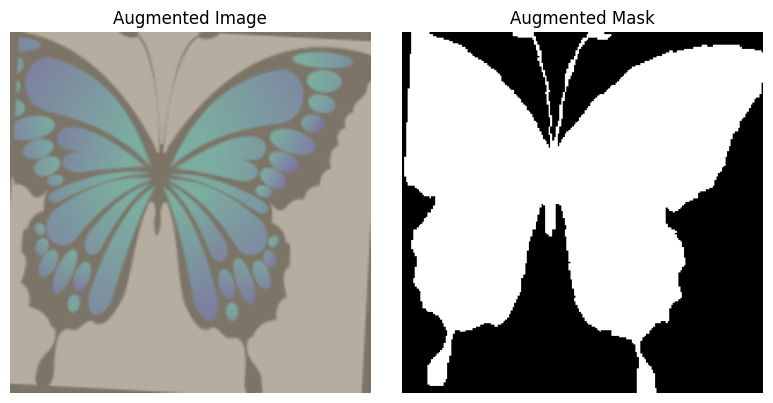

In [10]:
# Visual check: raw sample -> augmented sample (image and mask should stay aligned)
raw_ds = _Dataset(TRAIN_DIR, TRAIN_DIR)   # raw data (no transforms)
img_raw, mask_raw = raw_ds[0]    # PIL / tensor depending on your _Dataset implementation

# Apply combined augmentation (pair-wise)
img_t, mask_t = combined_aug(img_raw, mask_raw)

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def unnormalize_tensor(img_tensor):
    t = img_tensor.detach().cpu().clone()
    t = t * IMAGENET_STD + IMAGENET_MEAN
    return torch.clamp(t, 0.0, 1.0)

def to_numpy_for_plot(img, mask):
    # img: normalized tensor CxHxW or PIL
    if isinstance(img, torch.Tensor) and img.ndim == 3:
        img_u = unnormalize_tensor(img)
        img_np = img_u.permute(1,2,0).numpy()
    else:
        img_np = v2.ToImage()(img).permute(1,2,0).numpy()

    # mask -> HxW binary
    if isinstance(mask, torch.Tensor):
        m = Augmentation.sanitize_mask(mask)
        m_np = m.squeeze(0).cpu().numpy()
    else:
        m_np = Augmentation.sanitize_mask(v2.ToImage()(mask)).squeeze(0).numpy()

    return img_np, m_np

img_np, m_np = to_numpy_for_plot(img_t, mask_t)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.title("Augmented Image"); plt.imshow(img_np); plt.axis("off")
plt.subplot(1,2,2); plt.title("Augmented Mask");  plt.imshow(m_np, cmap="gray"); plt.axis("off")
plt.tight_layout(); plt.show()


After visualizing the images and masks, the results **look good** and masks appear correctly aligned with the objects.

## Training Phase DataLoaders

We create **DataLoaders** for the following three pipelines:

> **Pipelines:**  
> - `Plain`  
> - `Augmentation-Only`  
> - `Crop + Augmentation`  

We also **visualize samples** from each to verify the transformations.


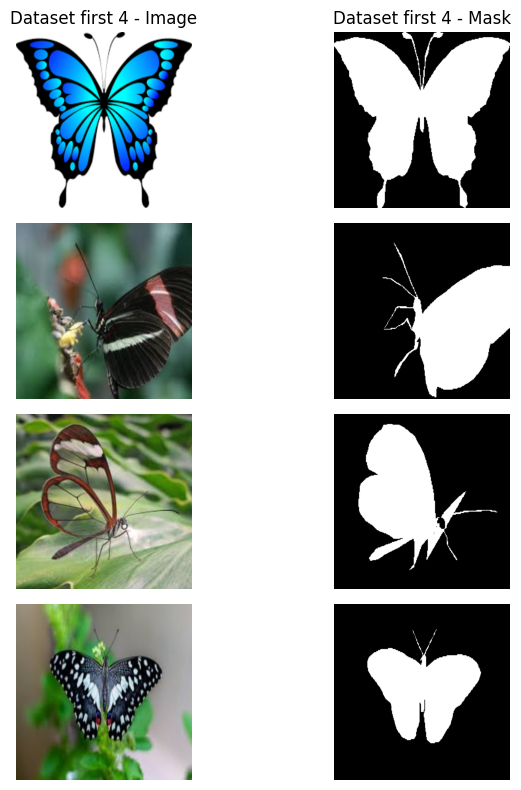

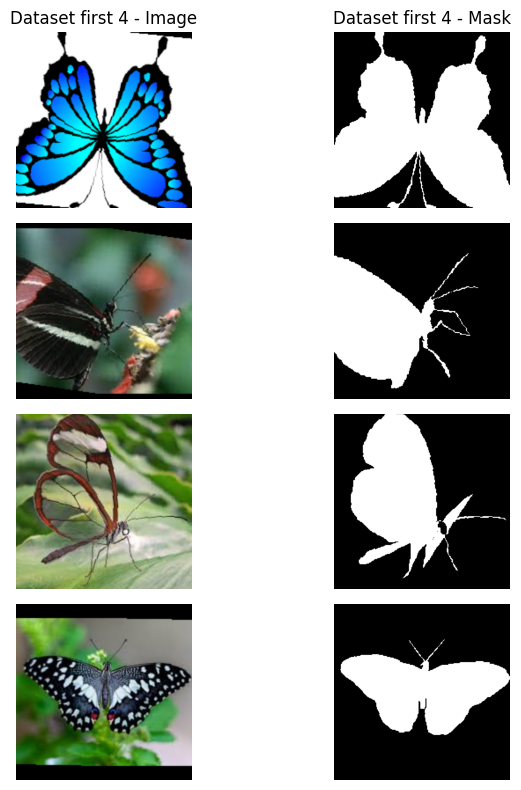

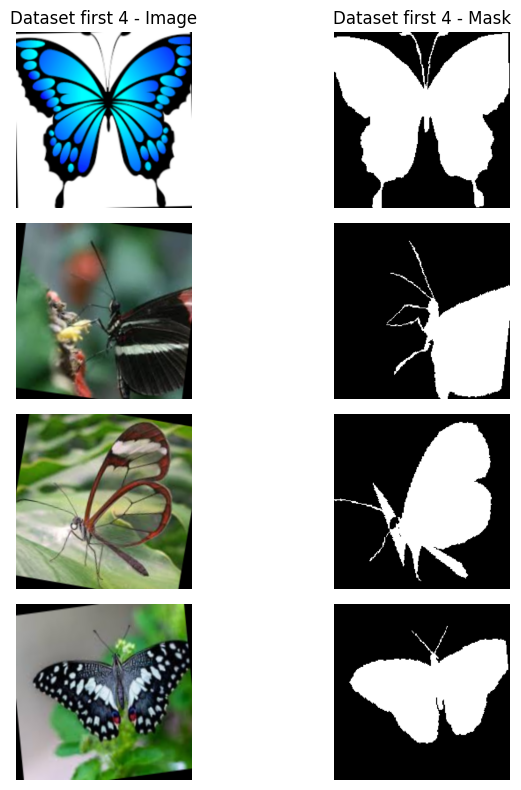

In [11]:
# 1️⃣ Plain dataset
train_loader_plain = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)
test_loader_plain = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

# 2️⃣ Augmentation-only dataset
train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)
test_loader_aug = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

# 3️⃣ Crop + augmentation dataset
train_loader_cropaug = DataLoader(
    train_dataset_cropaug,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)
test_loader_cropaug = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

visualize_samples(train_dataset)
visualize_samples(train_dataset_aug)
visualize_samples(train_dataset_cropaug)

## Dataset Comparison

In [12]:
#debug needed
#test = Test(train_loader_cropaug,test_loader_cropaug,1)
#test.train_all("test")

## Define heavy augmentation and pipeline

### Comparing Augmentation and Pretrained Models

- We further define pipelines to **compare the effect of different augmentations**.  
- Additionally, we include a **pretrained model pipeline** to evaluate its performance against training from scratch.


In [13]:
transform_heavy_geo = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.3),
    v2.RandomRotation(degrees=45),
    v2.RandomInvert(0.54),
    v2.CenterCrop(200),
    v2.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),  # Just in case spatial sizes changed
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])
# prepare optional transforms / loader for pretrained model
transform_plain_pretrained = v2.Compose([
    v2.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    
])

# difference between heavy augmentation and normal augmentation

train_dataset_aug_heavy = _Dataset(TRAIN_DIR, TRAIN_DIR, transform=transform_heavy_geo)
train_loader_aug_heavy = DataLoader(train_dataset_aug_heavy, batch_size=BATCH_SIZE,
                                      shuffle=True) #num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


# difference between pretrained resnet performance and training from scratch
train_dataset_pretrained_plain = _Dataset(TRAIN_DIR, TRAIN_DIR, transform=transform_plain_pretrained)
train_loader_pretrained_plain =  DataLoader(train_dataset_pretrained_plain, batch_size = BATCH_SIZE, shuffle = True)

# check is it loaded with correct shape and no error

for x in train_loader_aug_heavy:
    break
for x in train_loader_pretrained_plain:
    break

Found 600 image files
Found 600 image files


### Model Configuration and Reproducible Testing

- We define a **list of configurations** (`configs`) specifying:
  - Dataset loaders (`train_loader`, `test_loader`)  
  - Model classes (`UNet`, `AttentionUNet`, `AttentionR2UNet`, pretrained versions)  
  - Training and plotting flags  
  - Checkpoint directories  

- A **loop over `configs`** ensures reproducibility:  
  - If `train=True`, the model is trained and checkpoints saved.  
  - Otherwise, existing checkpoints are loaded, and metrics can be plotted if `plot=True`.  
- This setup allows **consistent comparison** across models, datasets, and augmentation strategies.


In [14]:
# ---------------- Configuration ----------------

configs = [   
    {
        "name": "plain",
        "train_loader": train_loader_pretrained_plain,
        "test_loader": test_loader_plain,
        "model_class": PretrainedAttentionR2UNet,
        "train": False,
        "plot": False,
        "checkpoints_dir": "checkpoints/pretrainAttentionR2UNet/plain"
    },
    
    {
        "name": "heavy_aug",
        "train_loader": train_loader_aug_heavy,
        "test_loader": test_loader_plain,
        "model_class": AttentionR2UNet,
        "train": False,
        "plot": False,
        "checkpoints_dir": "checkpoints/AttentionR2UNet/heavy_aug"
    }
    ,
    {
        "name": "plain_UNet",
        "train_loader": train_loader_plain,
        "test_loader": test_loader_plain,
        "model_class": UNet,
        "train": False,
        "plot": False,
        "checkpoints_dir": "checkpoints/UNet/"
    },
    
    {
        "name": "plain_AttentionUNet",
        "train_loader": train_loader_plain,
        "test_loader": test_loader_plain,
        "model_class": AttentionUNet,
        "train": False,
        "plot": False,
        "checkpoints_dir": "checkpoints/AttentionUNet/plain/"
    },
    {
        "name": "plain_Attention_R2_UNet",
        "train_loader": train_loader_plain,
        "test_loader": test_loader_plain,
        "model_class": AttentionR2UNet,
        "train": False,
        "plot": False,
        "checkpoints_dir": "checkpoints/AttentionR2UNet/plain/"
    },
    {
        "name": "cropaug_Attention_R2_UNet",
        "train_loader": train_loader_cropaug,
        "test_loader": test_loader_cropaug,
        "model_class": AttentionR2UNet,
        "train": False,
        "plot": False,
        "checkpoints_dir": "checkpoints/AttentionR2UNet/cropaug/"
    },
    {
        "name": "aug_Attention_R2_UNet",
        "train_loader": train_loader_aug,
        "test_loader": test_loader_aug,
        "model_class": AttentionR2UNet,
        "train": False,
        "plot": False,
        "checkpoints_dir": "checkpoints/AttentionR2UNet/aug/"
    }
]

# ---------------- Loop over configs ----------------
for cfg in configs:
    tester = Test(cfg["train_loader"], cfg["test_loader"], num_epochs=100, early_stop_patience=10, model=cfg["model_class"])
    checkpoint_dir = cfg["checkpoints_dir"]
    
    if cfg["train"]:
        print(f"Training {cfg['model_class'].__name__} for {cfg['name']} dataset...")
        tester.train_all(checkpoints_dir=checkpoint_dir)
    else:
        checkpoint_paths = sorted(glob.glob(os.path.join(checkpoint_dir, "epoch_*.pth.tar")))
        if checkpoint_paths:
            print(f"Found checkpoints for {cfg['name']} in {checkpoint_dir}")
            if cfg["plot"]:
                tester.plot_metrics(checkpoint_paths)
        else:
            print(f"No checkpoints found in '{checkpoint_dir}' for {cfg['name']}.")


Found checkpoints for plain in checkpoints/pretrainAttentionR2UNet/plain
Found checkpoints for heavy_aug in checkpoints/AttentionR2UNet/heavy_aug
Found checkpoints for plain_UNet in checkpoints/UNet/
Found checkpoints for plain_AttentionUNet in checkpoints/AttentionUNet/plain/
Found checkpoints for plain_Attention_R2_UNet in checkpoints/AttentionR2UNet/plain/
Found checkpoints for cropaug_Attention_R2_UNet in checkpoints/AttentionR2UNet/cropaug/
Found checkpoints for aug_Attention_R2_UNet in checkpoints/AttentionR2UNet/aug/


### Effect of Augmentation and Model Architecture

- **Augmented data** can improve quality and help the model learn more **generalized patterns** if applied correctly.  
- Using a **better architecture** like `AttentionR2UNet`, we test three pipelines:
  1. **Plain dataset**  
  2. **PyTorch standard augmentation**  
  3. **Custom mask-aware crop augmentation**  

### Metrics Tracked During Training

For each pipeline, we track the following **key metrics** along epochs:

- **Loss** – measures the error between predictions and ground truth.  
- **Dice coefficient** – evaluates overlap between predicted masks and true masks.  
- **Accuracy (Acc)** – measures pixel-wise correctness.  
- **Intersection over Union (IoU)** – measures the ratio of intersection to union between predicted and true masks.



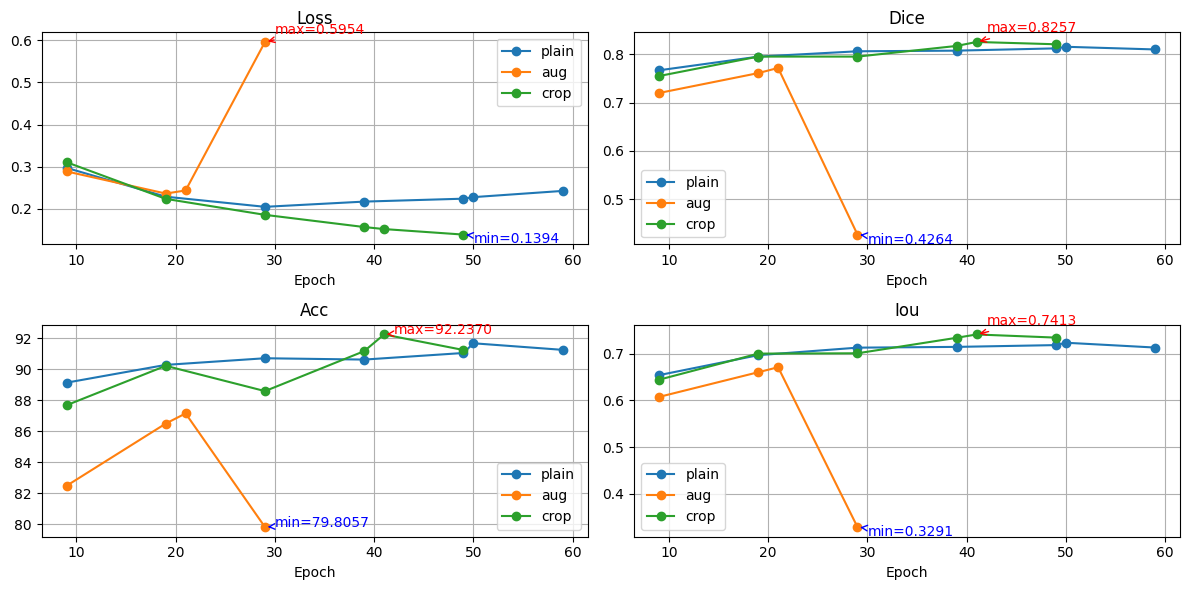

In [15]:

groups = { 
    "plain": "checkpoints/AttentionR2UNet/plain/*.pth.tar",
    "aug":   "checkpoints/AttentionR2UNet/aug/*.pth.tar",
    "crop":  "checkpoints/AttentionR2UNet/cropaug/*.pth.tar",
    
}
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
    
metrics_by_group = collect_and_plot(groups)





### Observations from Training

- **Crop-aware augmentation** achieves the **highest scores** across Dice, Accuracy, and IoU metrics.  
- The **normal augmentation** shows a **sudden increase in loss after ~20 epochs**, indicating overfitting.  
- **Plain dataset** and **crop-aware augmentation** plateau around epochs 40–60, but **crop-aware augmentation reaches the highest performance**, demonstrating the effectiveness of our pipeline.  

> ✅ Based on these results, we adopt the **mask-aware crop augmentation pipeline** for subsequent experiments.


Loading saved mAP results...


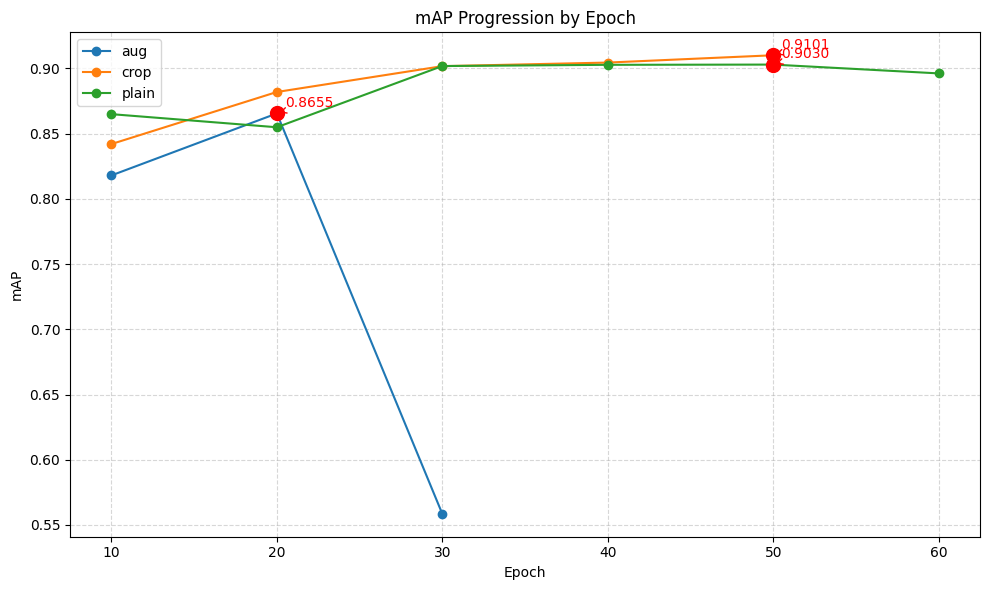

In [16]:
csv_path = "mAP_results_augmentation.csv"

# ---------------- Helper functions ----------------
def extract_epoch(path):
    """Extract epoch number from filename like epoch_10.pth.tar"""
    f = os.path.basename(path)
    m = re.search(r"epoch_(\d+)\.pth\.tar$", f)
    return int(m.group(1)) if m else -1

def load_model(path):
    """Load AttentionR2UNet checkpoint"""
    m = AttentionR2UNet()  # Replace with your actual model
    ckpt = torch.load(path, map_location=DEVICE)
    m.load_state_dict(ckpt["model_state_dict"])
    m.to(DEVICE).eval()
    return m

# ---------------- Load or Evaluate mAP ----------------
if os.path.exists(csv_path):
    print("Loading saved mAP results...")
    df = pd.read_csv(csv_path, index_col=0)
else:
    print("CSV not found. Evaluating mAP for all groups...")
    all_data = []
    for name, pat in groups.items():
        ckpts = sorted(glob.glob(pat), key=extract_epoch)
        ckpts = [p for p in ckpts if extract_epoch(p) != -1]
        if not ckpts:
            print(f"No epoch checkpoints found for {name}")
            continue

        print(f"\nEvaluating group: {name} ({len(ckpts)} checkpoints)")
        for ckpt in ckpts:
            ep = extract_epoch(ckpt)
            model = load_model(ckpt)
            with torch.no_grad():
                scores = [average_precision_score(y.cpu().ravel(), model(x.to(DEVICE)).cpu().ravel())
                          for x, y in test_loader]
            mean_ap = np.mean(scores)
            all_data.append({"Group": name, "Epoch": ep, "mAP": mean_ap})
            print(f"{name} | epoch {ep:>3}: mAP = {mean_ap:.4f}")

    df = pd.DataFrame(all_data)
    df.to_csv(csv_path)
    print(f"Saved mAP results to {csv_path}")

# ---------------- Pivot DataFrame ----------------
df_pivot = df.pivot(index="Epoch", columns="Group", values="mAP")

# ---------------- Highlight max per group and overall ----------------
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold; color: red' if v else '' for v in is_max]

def highlight_overall_max(df):
    max_val = df.values.max()
    return df.map(lambda v: 'font-weight: bold; color: darkred' if v==max_val else '')

styled = df_pivot.style.apply(highlight_max, axis=0).apply(highlight_overall_max, axis=None)
display(styled)

# ---------------- Plot mAP progression ----------------
plt.figure(figsize=(10,6))
for group, gdf in df.groupby("Group"):
    plt.plot(gdf["Epoch"], gdf["mAP"], marker='o', label=group)
    
    # Mark best mAP in this group
    best_idx = gdf["mAP"].idxmax()
    best_epoch = gdf.loc[best_idx, "Epoch"]
    best_map = gdf.loc[best_idx, "mAP"]
    plt.scatter(best_epoch, best_map, color='red', s=100, zorder=5)
    plt.annotate(f"{best_map:.4f}", xy=(best_epoch, best_map),
                 xytext=(best_epoch+0.5, best_map+0.005),
                 arrowprops=dict(arrowstyle="->", color='red'),
                 color='red')

plt.title("mAP Progression by Epoch")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### mAP Performance

- When evaluating **mean Average Precision (mAP)**, our **mask-aware crop augmentation pipeline** also achieves the **highest scores** compared to plain and standard augmentation pipelines.  
- This further confirms that our **pipeline improves both segmentation quality and generalization**.


## Comparison between augmentation effect (Visualization)

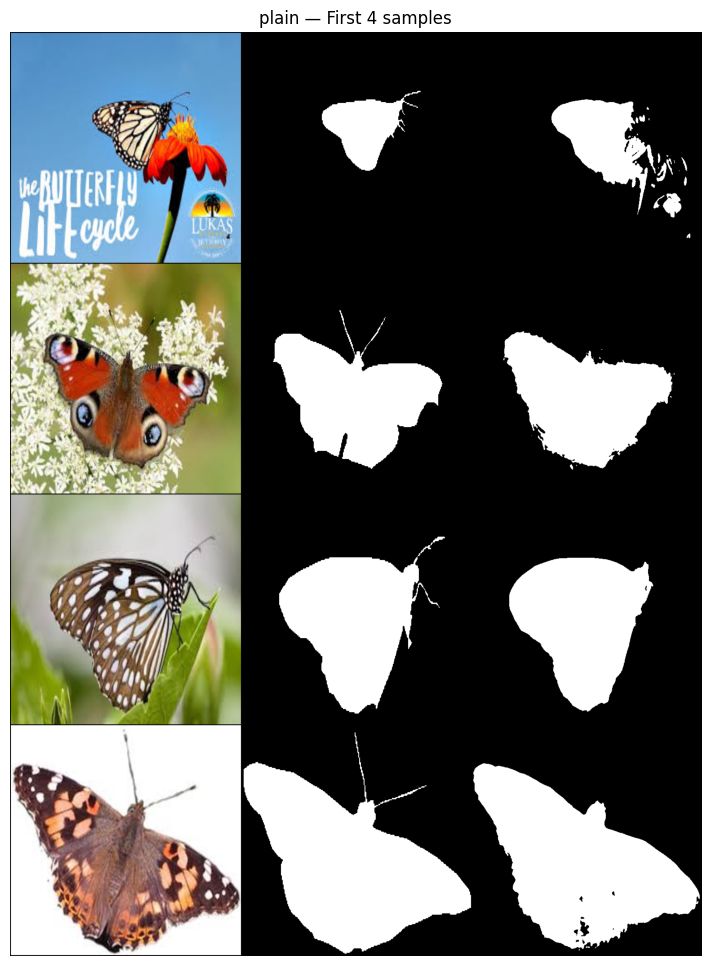

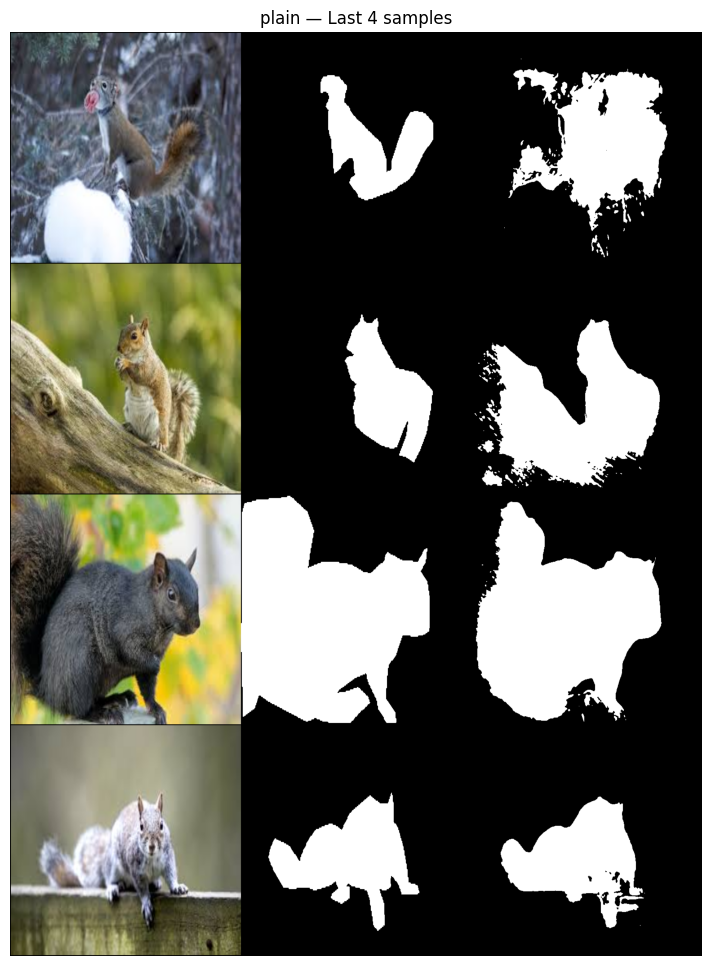

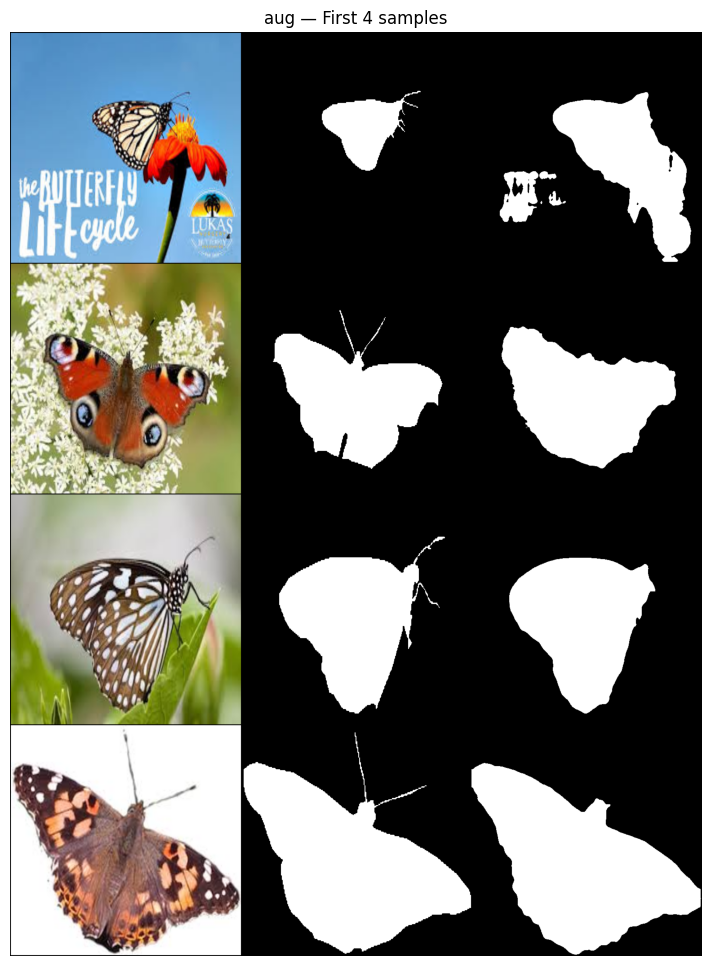

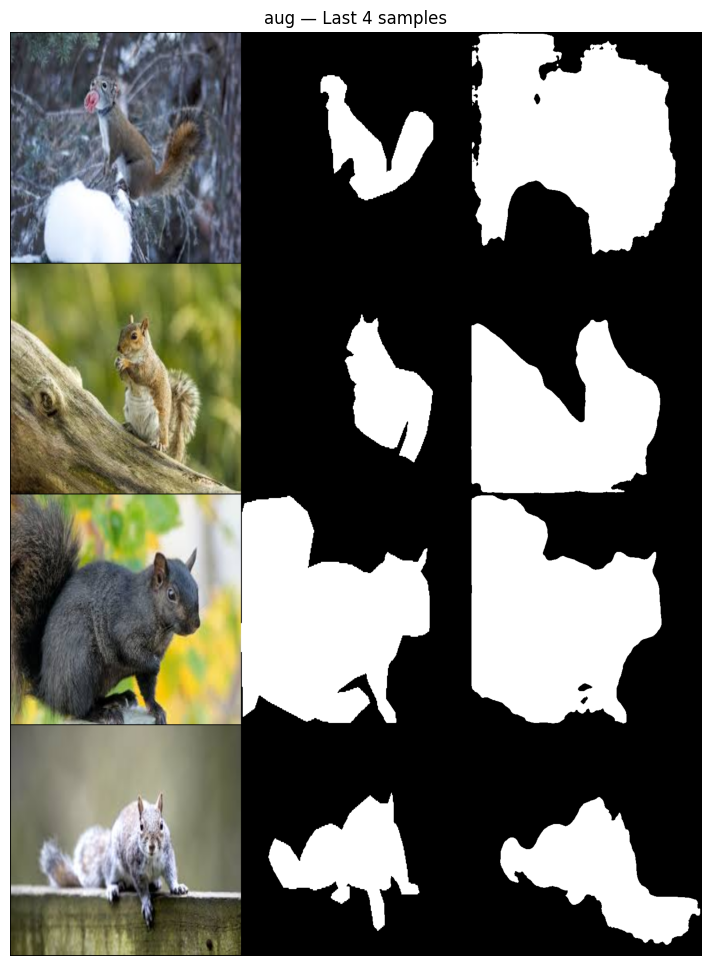

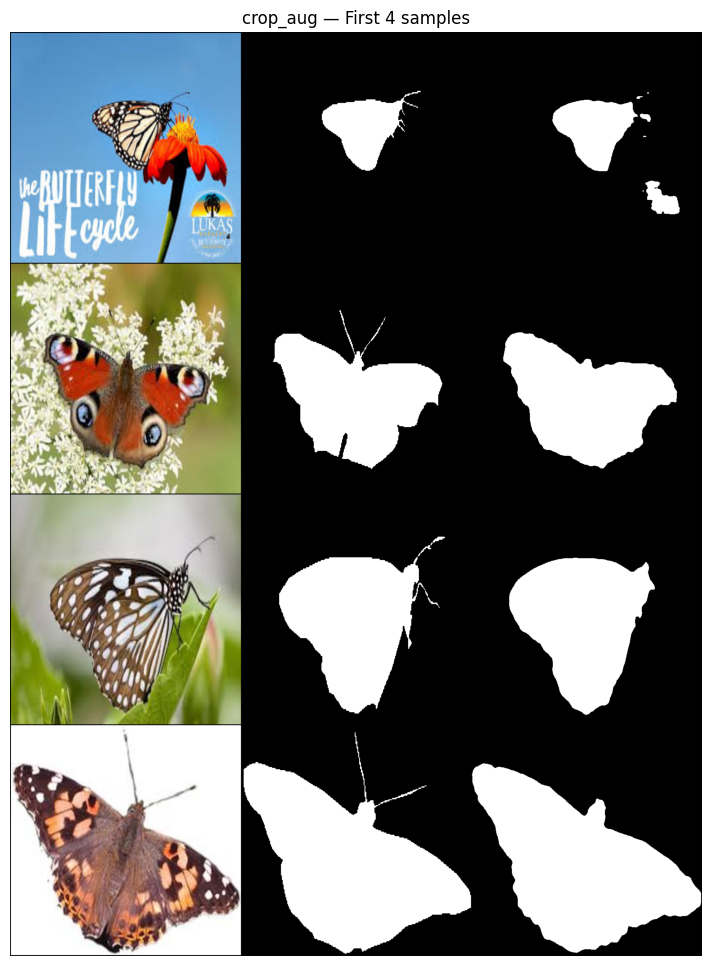

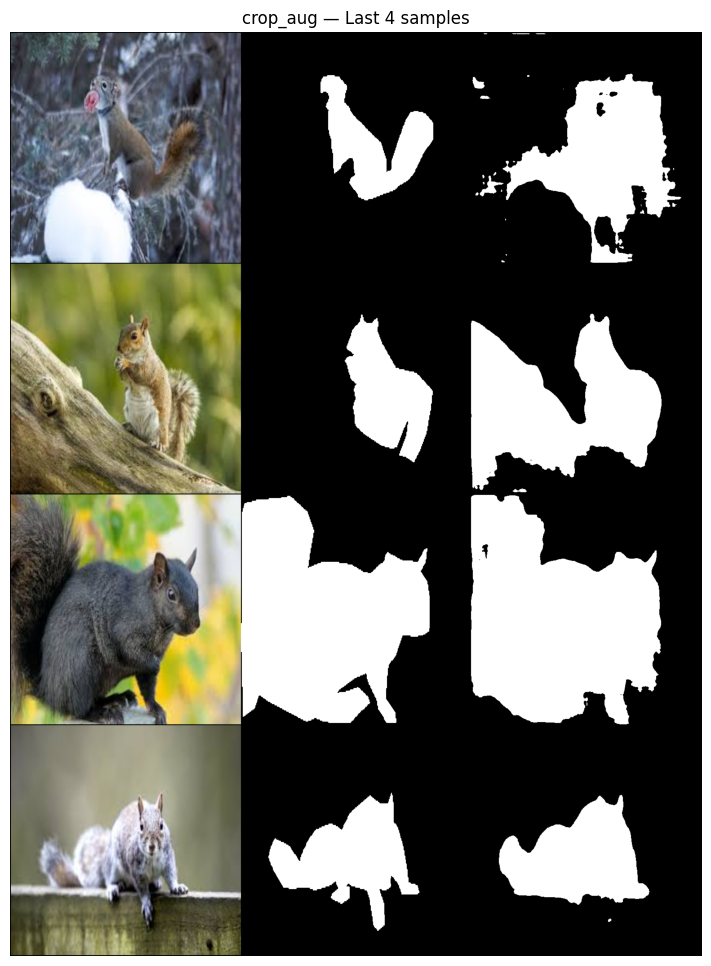

In [17]:

show_comparison("plain",   test_loader_plain,   "checkpoints/AttentionR2UNet/plain/best_checkpoint.pth.tar", n=4)
show_comparison("aug",     test_loader_aug,     "checkpoints/AttentionR2UNet/aug/best_checkpoint.pth.tar",   n=4)
show_comparison("crop_aug",test_loader_cropaug, "checkpoints/AttentionR2UNet/cropaug/best_checkpoint.pth.tar", n=4)



### Dice Coefficient Loss Testing

- We tested the **effect of combining BCE and Dice losses** using the formula:  
  - `0` → total **BCE loss** only  
  - `1` → total **Dice loss** only  
- Experiments were run on **Crop-Aware Augmentation** and **Plain datasets** using **AttentionR2UNet**, training from scratch for **3 epochs**.  
- This allows us to evaluate how the **loss weighting influences segmentation performance** early in training.


In [18]:
dice_train = False
if dice_train:
    for dice_co in [i/10 for i  in range(0,11)]:
        testdice_co = Test(train_loader_cropaug, test_loader_cropaug,3,2)
        testdice_co.train_all(f"checkpoints/dice/{dice_co}")
else:
    print("Skip training on loss function test.")


Skip training on loss function test.


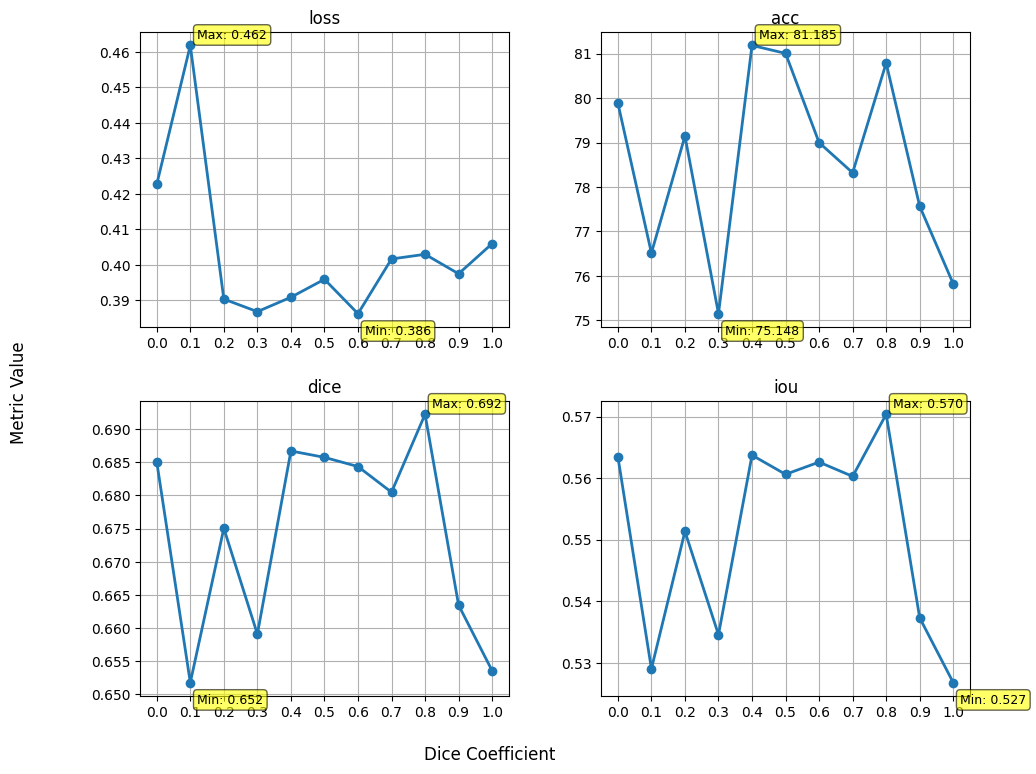

In [19]:
groups_dice = {}
for d in [i/10 for i in range(0,11)]:
    key = f"dice_{d:.1f}"
    path = f"checkpoints/dice/{d}/best_checkpoint.pth.tar"
    groups_dice[key] = path

keys = sorted(groups_dice, key=lambda k: float(k.split('_')[1]))
dice_vals = [float(k.split('_')[1]) for k in keys]
metrics = {m: [] for m in ["loss", "acc", "dice", "iou"]}

for k in keys:
    p = groups_dice[k]
    if not os.path.exists(p):
        [metrics[m].append(np.nan) for m in metrics]
        continue
    ck = torch.load(p, map_location="cpu")
    for m in metrics:
        metrics[m].append(float(ck.get(m, np.nan)))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, m in zip(axes.ravel(), metrics):
    vals = metrics[m]
    ax.plot(dice_vals, vals, marker='o', linewidth=2)
    ax.set_title(m)
    ax.set_xticks(dice_vals)
    ax.set_xticklabels([f"{v:.1f}" for v in dice_vals])
    ax.grid(True)

    # Annotate max and min points with boxed label
    max_idx = np.nanargmax(vals)
    min_idx = np.nanargmin(vals)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.6, edgecolor="black")

    ax.annotate(f"Max: {vals[max_idx]:.3f}", xy=(dice_vals[max_idx], vals[max_idx]),
                xytext=(5,5), textcoords='offset points', color='black', fontsize=9,
                bbox=bbox_props)
    ax.annotate(f"Min: {vals[min_idx]:.3f}", xy=(dice_vals[min_idx], vals[min_idx]),
                xytext=(5,-15), textcoords='offset points', color='black', fontsize=9,
                bbox=bbox_props)

fig.text(0.5, 0.04, "Dice Coefficient", ha='center', fontsize=12)
fig.text(0.02, 0.5, "Metric Value", va='center', rotation='vertical', fontsize=12)
plt.subplots_adjust(bottom=0.12, left=0.15, right=0.98, top=0.95, hspace=0.25, wspace=0.25)
plt.show()




## Choice of Loss Function

- After evaluating our checkpoints, we observed that the **optimal range** for the Dice coefficient weighting is roughly **0.4–0.8**, with only slight differences in performance within this range.  
- We chose **0.7** for Dice weighting because:
  - Dice is our **primary focus**.  
  - It **penalizes non-overlapping regions more**, which is important for our **small dataset**.  
- The final **combined loss function** is:

**Loss = 0.7 × DiceLoss + 0.3 × BCELoss**

- This setup allows us to **train for more epochs** while providing **augmentation** to improve generalization, especially on **larger image regions**.


# Architecture Comparison


## Segmentation Models Overview (Binary Mask Case)

We applied **transfer learning from ResNet34**. The pretrained features fit the data well, showing minimal differences from training from scratch.

---

## 1. UNet
- **Architecture**: Encoder-decoder with skip connections.  
- **Notes**: Captures most structures but struggles with small/thin objects like butterfly antennae.  
- **Formula**:  
$$
\hat{Y} = f_\text{dec}([f_\text{enc}^{(i)}, f_\text{dec}^{(i+1)}])
$$

---

## 2. UNet++
- **Architecture**: Nested UNet with dense skip connections.  
- **Notes**: Reduces semantic gap between encoder and decoder; **training is slower**.  
- **Formula**:  
$$
X^{i,j} = H([X^{i,k}]_{k=0}^{j-1}, U(X^{i+1,j-1}))
$$

---

## 3. Attention UNet
- **Architecture**: UNet + attention gates.  
- **Notes**: Focuses on relevant regions, improves segmentation of small or thin structures.  
- **Formula**:  
$$
\alpha = \sigma(\psi^T(\text{ReLU}(W_x x + W_g g + b)))
$$

---

## 4. Attention R2 UNet
- **Architecture**: Attention UNet + residual recurrent blocks.  
- **Notes**: Better feature propagation, captures context, more stable training.  
- **Formula**:  
$$
H^{t+1} = H^t + F(H^t, W)
$$

---

## 5. Pretrained Attention R2 UNet
- **Architecture**: Attention R2 UNet with **ResNet34 encoder**.  
- **Notes**: Fast convergence, strong initial performance, minimal effect from augmentation.  

---

## Understanding TP, TN, FP, FN (Binary Segmentation)

Before using the metrics formulas, it is important to define the **components of a confusion matrix** for binary masks:

- **TP (True Positive)**: Pixels correctly predicted as **foreground**.  
- **TN (True Negative)**: Pixels correctly predicted as **background**.  
- **FP (False Positive)**: Pixels incorrectly predicted as **foreground** (should be background).  
- **FN (False Negative)**: Pixels incorrectly predicted as **background** (should be foreground).  

These four quantities are the basis for calculating **Dice, IoU, Accuracy, Precision, Recall, and mAP** in binary segmentation.

## Common Metrics (Binary Mask)

Using **True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)**:

- **Dice Coefficient**:  
$$
\text{Dice} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}
$$

- **Intersection over Union (IoU)**:  
$$
\text{IoU} = \frac{TP}{TP + FP + FN}
$$

- **Accuracy (Acc)**:  
$$
\text{Acc} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- **Binary Cross-Entropy (BCE) Loss**:  
$$
\text{BCE} = - \frac{1}{N} \sum_i [g_i \log(p_i) + (1-g_i)\log(1-p_i)]
$$
(pixel-wise classification, unchanged)

- **Average Precision (AP / mAP)**:  
For **binary segmentation**, precision and recall are:  
$$
\text{Precision} = \frac{TP}{TP + FP}, \quad
\text{Recall} = \frac{TP}{TP + FN}
$$
Then AP is the **area under the precision-recall curve**:
$$
\text{AP} = \int_0^1 \text{Precision(Recall)} \, d(\text{Recall)}
$$
For binary masks, mAP reduces to evaluating **foreground pixel detection accuracy** across thresholds.


UNet (5 files): ['checkpoints/UNet\\best_checkpoint.pth.tar', 'checkpoints/UNet\\epoch_10.pth.tar', 'checkpoints/UNet\\epoch_20.pth.tar', 'checkpoints/UNet\\epoch_30.pth.tar', 'checkpoints/UNet\\epoch_40.pth.tar']
AttentionUNet (5 files): ['checkpoints/AttentionUNet/plain\\best_checkpoint.pth.tar', 'checkpoints/AttentionUNet/plain\\epoch_10.pth.tar', 'checkpoints/AttentionUNet/plain\\epoch_20.pth.tar', 'checkpoints/AttentionUNet/plain\\epoch_30.pth.tar', 'checkpoints/AttentionUNet/plain\\epoch_40.pth.tar']
AttentionR2UNet (7 files): ['checkpoints/AttentionR2UNet/plain\\best_checkpoint.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_10.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_20.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_30.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_40.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_50.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_60.pth.tar']
pretrainAttentionR2UNet (5 files): ['checkpoints/pretrainAttentionR2

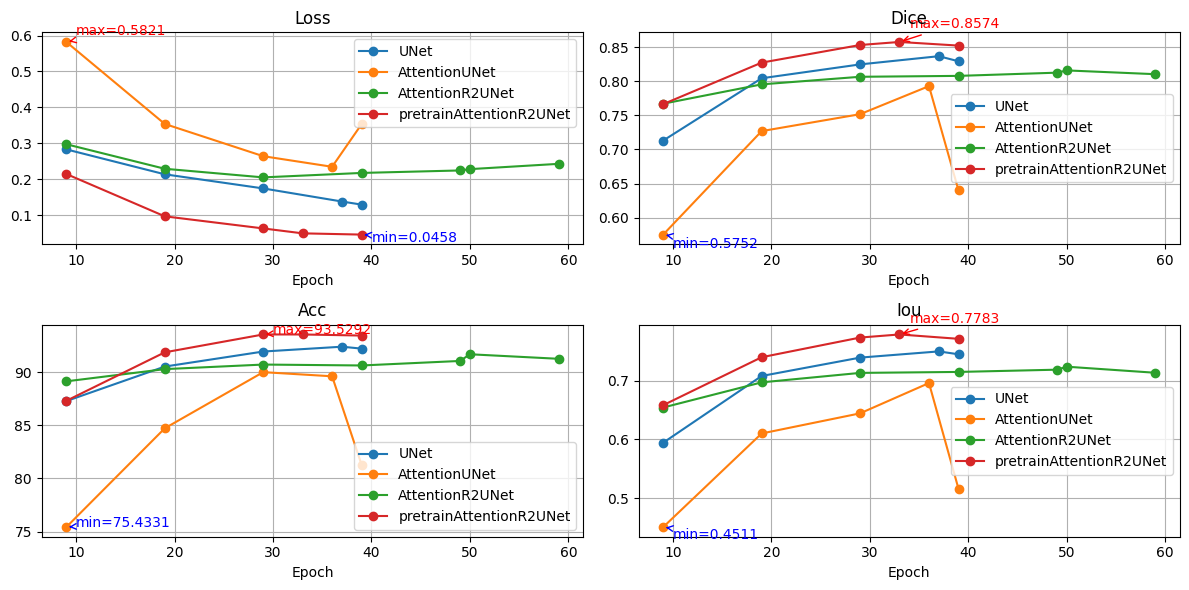

In [20]:

groups = { 
    "UNet": "checkpoints/UNet/*.pth.tar",
    "AttentionUNet":   "checkpoints/AttentionUNet/plain/*.pth.tar",
    "AttentionR2UNet":  "checkpoints/AttentionR2UNet/plain/*.pth.tar",
    "pretrainAttentionR2UNet":"checkpoints/pretrainAttentionR2UNet/plain/*.pth.tar"
    
}

for name, pattern in groups.items():
    files = glob.glob(pattern)
    print(f"{name} ({len(files)} files): {files}")


test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
    
metrics_by_group = collect_and_plot(groups)


UNet (5 files): ['checkpoints/UNet\\best_checkpoint.pth.tar', 'checkpoints/UNet\\epoch_10.pth.tar', 'checkpoints/UNet\\epoch_20.pth.tar', 'checkpoints/UNet\\epoch_30.pth.tar', 'checkpoints/UNet\\epoch_40.pth.tar']
AttentionUNet (5 files): ['checkpoints/AttentionUNet/plain\\best_checkpoint.pth.tar', 'checkpoints/AttentionUNet/plain\\epoch_10.pth.tar', 'checkpoints/AttentionUNet/plain\\epoch_20.pth.tar', 'checkpoints/AttentionUNet/plain\\epoch_30.pth.tar', 'checkpoints/AttentionUNet/plain\\epoch_40.pth.tar']
AttentionR2UNet (7 files): ['checkpoints/AttentionR2UNet/plain\\best_checkpoint.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_10.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_20.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_30.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_40.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_50.pth.tar', 'checkpoints/AttentionR2UNet/plain\\epoch_60.pth.tar']
PretrainedAttentionR2UNet (5 files): ['checkpoints/pretrainAttention

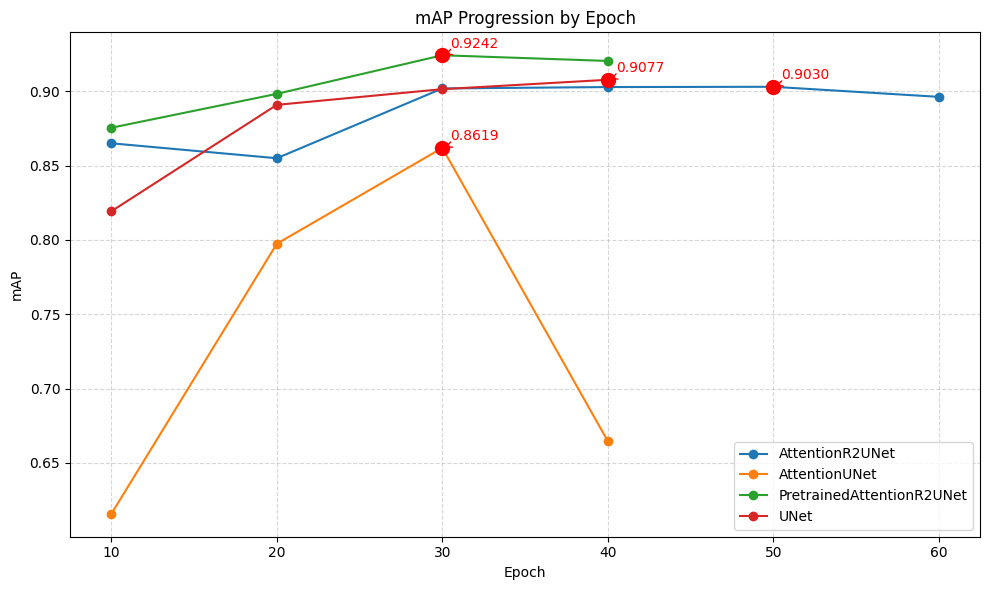

In [21]:
csv_path = "mAP_results_architecture.csv"

# ---------------- Helper functions ----------------
def extract_epoch(path):
    f = os.path.basename(path)
    m = re.search(r"epoch_(\d+)\.pth\.tar$", f)
    return int(m.group(1)) if m else -1

def load_model(path, name):
    """Dynamically load model based on group name or path"""
    # Check pretrained first
    if "pretrainAttentionR2UNet" in path or "PretrainedAttentionR2UNet" in name:
        model = PretrainedAttentionR2UNet()
    elif "AttentionR2UNet" in name:
        model = AttentionR2UNet()
    elif "AttentionUNet" in name:
        model = AttentionUNet()
    elif "UNet" in name:
        model = UNet()
    else:
        raise ValueError(f"Unknown model type for group '{name}'")
    
    ckpt = torch.load(path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    model.to(DEVICE).eval()
    return model

    
    ckpt = torch.load(path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    model.to(DEVICE).eval()
    return model

# ---------------- Core function ----------------
def collect_and_plot(groups):
    if os.path.exists(csv_path):
        print("Loading saved mAP results...")
        df = pd.read_csv(csv_path, index_col=0)
    else:
        print("CSV not found. Evaluating mAP for all groups...")
        all_data = []
        for name, pat in groups.items():
            ckpts = sorted(glob.glob(pat), key=extract_epoch)
            ckpts = [p for p in ckpts if extract_epoch(p) != -1]
            if not ckpts:
                print(f"No epoch checkpoints found for {name}")
                continue

            print(f"\nEvaluating group: {name} ({len(ckpts)} checkpoints)")
            for ckpt in ckpts:
                ep = extract_epoch(ckpt)
                model = load_model(ckpt, name)
                with torch.no_grad():
                    scores = []
                    for x, y in test_loader:
                        preds = model(x.to(DEVICE))
                        scores.append(
                            average_precision_score(
                                y.cpu().numpy().ravel(), preds.cpu().numpy().ravel()
                            )
                        )
                mean_ap = np.mean(scores)
                all_data.append({"Group": name, "Epoch": ep, "mAP": mean_ap})
                print(f"{name} | epoch {ep:>3}: mAP = {mean_ap:.4f}")

        df = pd.DataFrame(all_data)
        df.to_csv(csv_path)
        print(f"Saved mAP results to {csv_path}")

    # ---------------- Pivot and highlight ----------------
    df_pivot = df.pivot(index="Epoch", columns="Group", values="mAP")

    def highlight_max(s):
        is_max = s == s.max()
        return ['font-weight: bold; color: red' if v else '' for v in is_max]

    def highlight_overall_max(df):
        max_val = df.values.max()
        return df.map(lambda v: 'font-weight: bold; color: darkred' if v == max_val else '')

    styled = df_pivot.style.apply(highlight_max, axis=0).apply(highlight_overall_max, axis=None)
    display(styled)

    # ---------------- Plot mAP progression ----------------
    plt.figure(figsize=(10, 6))
    for group, gdf in df.groupby("Group"):
        plt.plot(gdf["Epoch"], gdf["mAP"], marker='o', label=group)
        best_idx = gdf["mAP"].idxmax()
        best_epoch = gdf.loc[best_idx, "Epoch"]
        best_map = gdf.loc[best_idx, "mAP"]
        plt.scatter(best_epoch, best_map, color='red', s=100, zorder=5)
        plt.annotate(f"{best_map:.4f}", xy=(best_epoch, best_map),
                     xytext=(best_epoch + 0.5, best_map + 0.005),
                     arrowprops=dict(arrowstyle="->", color='red'),
                     color='red')

    plt.title("mAP Progression by Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.grid(True, ls='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_pivot


# ---------------- Example Usage ----------------
groups = { 
    "UNet": "checkpoints/UNet/*.pth.tar",
    "AttentionUNet": "checkpoints/AttentionUNet/plain/*.pth.tar",
    "AttentionR2UNet": "checkpoints/AttentionR2UNet/plain/*.pth.tar",
    "PretrainedAttentionR2UNet": "checkpoints/pretrainAttentionR2UNet/plain/*.pth.tar"
}

for name, pattern in groups.items():
    files = glob.glob(pattern)
    print(f"{name} ({len(files)} files): {files}")

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
metrics_by_group = collect_and_plot(groups)


### Training Observations

- Due to **computational constraints**, we only trained the **plain dataset** and compared different architectures.  
- With the **small dataset**, **UNet** tends to fit better, especially when pretrained.  
- **Attention UNet** and **Attention R2 UNet** performed worse, likely because:
  - No augmentation was applied.  
  - Overfitting occurred, visible from the **increase in loss** for Attention UNet.  
- To improve performance, we **introduced transfer learning using a ResNet34 encoder**, which fit the data well and **achieved the best results**.  
- This highlights the importance of **pretrained weights, augmentation, and regularization** for complex architectures on small datasets.


In [22]:


groups = { 
    "UNet": "checkpoints/UNet/*.pth.tar",
    "AttentionUNet": "checkpoints/AttentionUNet/plain/*.pth.tar",
    "AttentionR2UNet": "checkpoints/AttentionR2UNet/plain/*.pth.tar",
    "PretrainedAttentionR2UNet": "checkpoints/pretrainAttentionR2UNet/plain/*.pth.tar"
}

indices_to_show = [0]   # indices you want to visualize
FIGSIZE = (6,6)         # figure size for displaying images

markdown_links = []     # collect Markdown links for all images

for model_name, ckpt_pattern in groups.items():
    save_dir = os.path.join("evolution_images", model_name)
    os.makedirs(save_dir, exist_ok=True)

    ckpt_paths = sorted(glob.glob(ckpt_pattern))
    if not ckpt_paths:
        print(f"No checkpoints for {model_name}, skipping...")
        continue

    # Instantiate model and Test object
    ModelClass = globals()[model_name]
    model = ModelClass(in_channels=3, out_channels=1).to(DEVICE)
    test_obj = Test(train_loader_pretrained_plain, test_loader_plain, model=model)

    for idx in indices_to_show:
        img_path = os.path.join(save_dir, f"mask_evolution_idx_{idx}.png")

        if os.path.exists(img_path):
            print(f"[{model_name}] Image already exists for index {idx}, skipping.")
        else:
            print(f"[{model_name}] Generating image for index {idx}")
            test_obj.visualize_binary_mask_evolution(
                indices=[idx],
                test_dataset=test_dataset,
                checkpoint_paths=ckpt_paths,
                threshold=0.5,
                col=5,
                base_figsize=FIGSIZE,
                show_prob_map=True,
                save_dir=save_dir
            )

        # Record markdown path
        rel_path = img_path.replace("\\", "/")
        markdown_links.append(f"- **{model_name} (index {idx})**: [View Image]({rel_path})")

# Print Markdown summary
print("\n### 🖼️ Mask Evolution Images\n")
print("```markdown")
for link in markdown_links:
    print(link)
print("```")


[UNet] Image already exists for index 0, skipping.
[AttentionUNet] Image already exists for index 0, skipping.
[AttentionR2UNet] Image already exists for index 0, skipping.


C:\Users\cky11\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cky11\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[PretrainedAttentionR2UNet] Image already exists for index 0, skipping.

### 🖼️ Mask Evolution Images

```markdown
- **UNet (index 0)**: [View Image](evolution_images/UNet/mask_evolution_idx_0.png)
- **AttentionUNet (index 0)**: [View Image](evolution_images/AttentionUNet/mask_evolution_idx_0.png)
- **AttentionR2UNet (index 0)**: [View Image](evolution_images/AttentionR2UNet/mask_evolution_idx_0.png)
- **PretrainedAttentionR2UNet (index 0)**: [View Image](evolution_images/PretrainedAttentionR2UNet/mask_evolution_idx_0.png)
```


## 🧩 Segmentation Evolution Overview

This figure shows how the model’s segmentation improves over training.

**From left to right:**
1. **Input Image** – the raw sample.  
2. **Ground Truth** – correct segmentation.  
3. **Predictions (every 10 epochs)** – how the mask evolves during training.  
4. **Best Epoch** – prediction with highest mAP/Dice/IoU.  
5. **Flow-by Probability Heatmap** – pixel change visualization.

**Heatmap colors:**
- 🟥 **Red:** pixel became wrong (lost correctness).  
- 🟩 **Green:** new correct pixel gained.  
- ⚪ **White:** pixel stayed correct (stable).  

This highlights where the model learns (green), forgets (red), and remains consistent (white) over time.


- **UNet (index 0)**: [View Image](evolution_images/UNet/mask_evolution_idx_0.png)
- **AttentionUNet (index 0)**: [View Image](evolution_images/AttentionUNet/mask_evolution_idx_0.png)
- **AttentionR2UNet (index 0)**: [View Image](evolution_images/AttentionR2UNet/mask_evolution_idx_0.png)
- **PretrainedAttentionR2UNet (index 0)**: [View Image](evolution_images/PretrainedAttentionR2UNet/mask_evolution_idx_0.png)

In [23]:
# 1. Instantiate the model
model = PretrainedAttentionR2UNet(
    in_channels=3,
    out_channels=1
).to(DEVICE)

# 2. Load trained weights
chk = torch.load(r"checkpoints\pretrainAttentionR2Unet\plain\best_checkpoint.pth.tar", map_location=DEVICE)
state_dict = chk.get('model_state_dict', chk)  # fallback if key doesn't exist
model.load_state_dict(state_dict)

# 3. Set to eval mode
model.eval()

# 4. Evaluate
acc, dice, iou = check_accuracy(test_loader_plain, model, device=DEVICE)

print(f"Pixel Accuracy: {acc:.2f}%")
print(f"Mean Dice: {dice:.4f}")
print(f"Mean IoU: {iou:.4f}")


Pixel Accuracy: 93.53%
Mean Dice: 0.8574
Mean IoU: 0.7783


In [24]:
from sklearn.metrics import average_precision_score
import numpy as np
import torch

test_loader_plain = DataLoader(test_dataset, batch_size=2, shuffle=False)
# Make sure model is in eval mode
model.eval()

map_scores = []

with torch.no_grad():
    for x, y in test_loader_plain:
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        # Get model output (already sigmoid if your model outputs sigmoid)
        probs = model(x)
        # If your model outputs logits, uncomment the next line
        # probs = torch.sigmoid(probs)
        
        # Move to CPU and flatten to compute average precision
        batch_map = average_precision_score(y.cpu().numpy().ravel(),
                                            probs.cpu().numpy().ravel())
        map_scores.append(batch_map)

# Dataset-wide mAP
dataset_map = np.mean(map_scores)

print(f"Dataset mAP: {dataset_map:.4f}")


Dataset mAP: 0.9245


# Model & Training Summary

**Architecture:** `Pretrained Attention R2-UNet (ResNet backbone)`

## Training Parameters
- **Batch size:** `8`
- **Learning rate:** `1e-4`
- **Optimizer:** `AdamW`
- **Loss function:** `Combined loss (0.7 Dice coefficient weight)`

## Performance Metrics
- **Pixel Accuracy:** `93.53%` → Most pixels correctly classified
- **Mean Dice:** `0.8574` → High overlap between predicted and ground truth masks
- **Mean IoU:** `0.7783` → Good agreement between predictions and labels
- **Dataset mAP:** `0.9245` → Excellent overall segmentation accuracy

## Conclusion
The `Pretrained Attention R2-UNet with ResNet backbone`, trained with a combined loss emphasizing Dice (`0.7` weight), shows excellent segmentation performance on this dataset. The selected hyperparameters (`batch size 8`, `lr 1e-4`, `AdamW optimizer`) provide stable training and effective learning, achieving high pixel-level accuracy and strong mask overlap. This configuration is suitable for deployment or further fine-tuning for even more precise segmentation.
